# Fine-Tuning DenseNet121 for Image Classification
*By Carlos Santiago Bañón*

**Year:** 2020

**Technologies:** Python, TensorFlow, Keras, Matplotlib, NumPy, TeX, Jupyter Notebook

**Discipline(s):** Computer Vision

**Keywords:** `computer-vision`, `cnn`, `convolutional-neural-network`, `deep-learning`, `image-classification`, `densenet121`

This notebook shows the use of a pretrained *Convolutional Neural Network (CNN)* on a large data set from Google, containing 2,000 JPG images of cats and dogs.

In *Deep Learning with Python*, François Chollet defines pretrained networks as "a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task."

Here, we employ the [DenseNet121](https://keras.io/applications/#densenet) convolutional base for feature extraction. These are then run through a new classifier trained from scratch. With it, we then use data augmentation, fine-tuning, and no dropout.

## 1. Get the Data

---

### 1.1. Download and Extract the Data from Google

First, we download the data from Google, which containes 2,000 JPG images of cats and dogs. These are extracted locally in `/tmp`.

In [ ]:
# Download the data from Google.

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-22 01:05:57--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   297MB/s    in 0.2s    

2020-04-22 01:05:57 (297 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile

# Unzip the file and extract the data.
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

### 1.2. Split the Data into Training and Validation Sets

We then take this data and split it into training and validation sets. It must be noted that the data provided by Google does not have a test set.

In [ ]:
# Split the data into training and validation sets.

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures.
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures.
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures.
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures.
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## 2. Build the New Model

---

Once we have the data ready, we can proceed to build the new model using the pretrained DenseNet convolutional base. This will then be concatenated with a newly-trained custom set of densely-connected layers.

### 2.1. Load the Convolutional Base

First, load the pretrained DenseNet convolutional base.

In [ ]:
from keras.applications import DenseNet121

conv_base = DenseNet121(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

Using TensorFlow backend.


### 2.2. Freeze the Convolutional Base

Once the pretrained convolutional base is ready, freeze it by setting its `trainable` attribute to `False`.

In [ ]:
conv_base.trainable = False

### 2.3. Add a Densely-Connected Classifier on Top of the Convolutional Base

After freezing the pretrained model, we can then proceed to add a densely-connected classifier on top of the convolutional base. This will provide more specific results for our problem.

In [ ]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 4, 4, 1024)        7037504   
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4194560   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 11,232,321
Trainable params: 4,194,817
Non-trainable params: 7,037,504
_________________________________________________________________


### 2.4. Train the Model End to End with a Frozen Convolutional Base

After concatenating the pretrained model and the densely-connected layers, the next step is to train the model end to end with the frozen convolutional base.

First, we use data augmentation.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

In [ ]:
# Use data augmentation.

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Then, we compile and train the model.

In [ ]:
# Compile the model.

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

In [ ]:
# Train the model.

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/30
100/100 [==============================] - 26s 260ms/step - loss: 0.3753 - acc: 0.8230 - val_loss: 0.3794 - val_acc: 0.9390
Epoch 2/30
100/100 [==============================] - 18s 182ms/step - loss: 0.2499 - acc: 0.8855 - val_loss: 0.0079 - val_acc: 0.9430
Epoch 3/30
100/100 [==============================] - 18s 180ms/step - loss: 0.2458 - acc: 0.8925 - val_loss: 0.0091 - val_acc: 0.9440
Epoch 4/30
100/100 [==============================] - 18s 181ms/step - loss: 0.2317 - acc: 0.9035 - val_loss: 0.1025 - val_acc: 0.9590
Epoch 5/30
100/100 [==============================] - 18s 180ms/step - loss: 0.2086 - acc: 0.9115 - val_loss: 0.0980 - val_acc: 0.9540
Epoch 6/30
100/100 [==============================] - 18s 181ms/step - loss: 0.1905 - acc: 0.9160 - val_loss: 0.0282 - val_acc: 0.9370
Epoch 7/30
100/100 [==============================] - 18s 182ms/step - loss: 0.2275 - acc: 0.9060 - val_loss: 0.1580 - val_acc: 0.9490
Epoch 8/30
100/100 [==============================] - 1

### 2.5. Show Loss and Accuracy Curves During Training

After the training phase is complete, we can then visualize the training and validation accuracy and loss using *Matplotlib*.

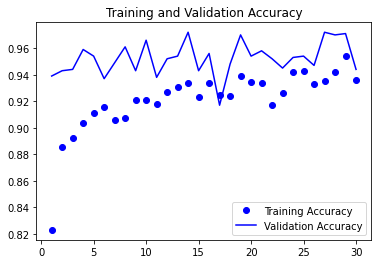

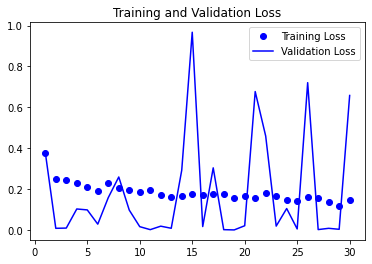

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Training and Validation Accuracy

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

# Training and Validation Loss

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

## 3. Perform Fine-Tuning

---

After the initial training phase, we can use *fine-tuning* to get a higher accuracy.

### 3.1. Freeze All Layers Up to a Specific One

First, we must freeze all the layers up to a specific one.

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

### 3.2. Recompile and Train the Model with Fine-Tuning

Then, we recompile the model and train it once more with the fine-tuning.

In [ ]:
# Recompile the model.

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

In [ ]:
# Train the model.

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 28s 282ms/step - loss: 0.1485 - acc: 0.9390 - val_loss: 0.1357 - val_acc: 0.9670
Epoch 2/100
100/100 [==============================] - 20s 198ms/step - loss: 0.1278 - acc: 0.9485 - val_loss: 0.1359 - val_acc: 0.9690
Epoch 3/100
100/100 [==============================] - 20s 199ms/step - loss: 0.1308 - acc: 0.9435 - val_loss: 0.2101 - val_acc: 0.9640
Epoch 4/100
100/100 [==============================] - 20s 199ms/step - loss: 0.1418 - acc: 0.9395 - val_loss: 0.0171 - val_acc: 0.9590
Epoch 5/100
100/100 [==============================] - 20s 197ms/step - loss: 0.1675 - acc: 0.9340 - val_loss: 0.0088 - val_acc: 0.9660
Epoch 6/100
100/100 [==============================] - 20s 198ms/step - loss: 0.1298 - acc: 0.9505 - val_loss: 0.0945 - val_acc: 0.9590
Epoch 7/100
100/100 [==============================] - 20s 201ms/step - loss: 0.1212 - acc: 0.9500 - val_loss: 0.0825 - val_acc: 0.9650
Epoch 8/100
100/100 [===========================

### 3.3. Show Loss and Accuracy Curves During Training Using Fine-Tuning

Once the new training phase is done, we can then use *Matplotlib* once more to show the loss and accuracy curves.

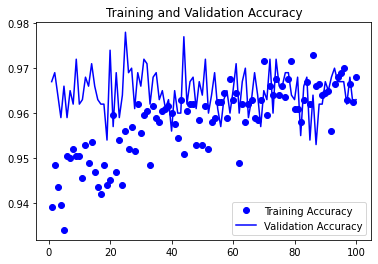

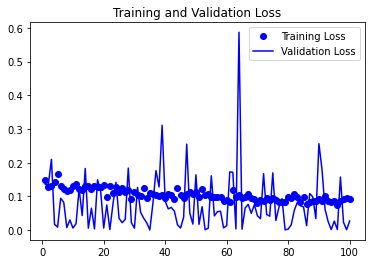

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Training and Validation Accuracy

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

# Training and Validation Loss

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

### 3.4. Display the Validation Loss and Accuracy

Finally, we can simply print out the values for the validation loss and accuracy.

In [ ]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [ ]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.010449341498315334
Validation accuracy: 0.9629999995231628
